In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 3.5MB/s 
     |████████████████████████████████| 890kB 14.9MB/s 
     |████████████████████████████████| 1.0MB 20.7MB/s 
     |████████████████████████████████| 3.7MB 29.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=739957b7f45194289bc9bd6c4c09fdc1e67b19b2bd6983968eba81a836692803
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [2]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.3MB/s 
     |████████████████████████████████| 112kB 23.7MB/s 
     |████████████████████████████████| 460kB 19.9MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=78bd3451ad11bc6ea509a85c4d1e56ab9da89986ec521290d788919cd6e7a6e4
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=19d3721f44b9f8220ff8b9ca6faa390107e8ddd63d77b9bf20d7e7c58644d9d9
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=7

In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 0f899bbf33dae82e8872c7b94e506e9e25177178
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import wandb
wandb.init(project="bert_ita_train")

W&B Run: https://app.wandb.ai/flaviodipalo/bert_ita_train/runs/ucrr2pis

In [5]:
%%writefile utils.py 

# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" BERT classification fine-tuning: utilities to work with GLUE tasks """

from __future__ import absolute_import, division, print_function

import csv
import logging
import os
import sys
from io import open

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score

from multiprocessing import Pool, cpu_count
from tqdm import tqdm

logger = logging.getLogger(__name__)
csv.field_size_limit(2147483647)

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None,lang_id=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        self.lang_id = lang_id



class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id,lang_id=None):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.lang_id = lang_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class BinaryProcessor(DataProcessor):
    """Processor for the binary data sets"""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            #lang_id = line[4]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label, lang_id=None))
        return examples


def convert_example_to_feature(example_row, pad_token=0,
sequence_a_segment_id=0, sequence_b_segment_id=1,
cls_token_segment_id=1, pad_token_segment_id=0,
mask_padding_with_zero=True):

    example, label_map, max_seq_length, tokenizer, output_mode, cls_token_at_end, cls_token, sep_token, cls_token_segment_id, pad_on_left, pad_token_segment_id = example_row

    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids:   0   0   0   0  0     0   0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = tokens_a + [sep_token]
    segment_ids = [sequence_a_segment_id] * len(tokens)

    if tokens_b:
        tokens += tokens_b + [sep_token]
        segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

    if cls_token_at_end:
        tokens = tokens + [cls_token]
        segment_ids = segment_ids + [cls_token_segment_id]
    else:
        tokens = [cls_token] + tokens
        segment_ids = [cls_token_segment_id] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    if pad_on_left:
        input_ids = ([pad_token] * padding_length) + input_ids
        input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
        segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
    else:
        input_ids = input_ids + ([pad_token] * padding_length)
        input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    #lang_ids = [int(example.lang_id)]*max_seq_length
    #assert len(lang_ids) == max_seq_length

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id,
                        lang_id = None)
    
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True,
                                 process_count=cpu_count() - 2):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}
    
    examples = [(example, label_map, max_seq_length, tokenizer, output_mode, cls_token_at_end, cls_token, sep_token, cls_token_segment_id, pad_on_left, pad_token_segment_id) for example in examples]

    with Pool(process_count) as p:
        features = list(tqdm(p.imap(convert_example_to_feature, examples, chunksize=100), total=len(examples)))

    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


processors = {
    "binary": BinaryProcessor
}

output_modes = {
    "binary": "classification"
}

GLUE_TASKS_NUM_LABELS = {
    "binary": 2
}


Writing utils.py


In [6]:
!mkdir data

from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange


from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer, 
                                  DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer)

from transformers import AdamW, get_linear_schedule_with_warmup

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



args = {
    'data_dir': 'data/',
    'model_type': 'distilbert',
    'model_name':'distilbert-base-uncased',
    #'model_name':'distilbert-base-multilingual-cased',
    #'model_type': 'xlm',
    #'model_name':'xlm-mlm-17-1280',
    
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    #'output_mode': 'classification',
    'output_mode': 'regression',
    'train_batch_size': 4,
    'eval_batch_size': 4,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 45,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': True,
    'reprocess_input_data': True,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer), 
    'distilbert': (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [11]:
config = config_class.from_pretrained(args['model_name'], num_labels=1, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])
#config = config_class(dropout=0.1, attention_dropout=0.1,seq_classif_dropout=0.2,num_labels=1)
#tokenizer = tokenizer_class()

INFO:filelock:Lock 139639536348016 acquired on /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmptahhd6u5


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json in cache at /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
INFO:filelock:Lock 139639536348016 released on /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e

INFO:filelock:Lock 139639536346728 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpa6l3wx6x


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:filelock:Lock 139639536346728 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f7

In [0]:
ENGLISH = False ## used to chose between the english and italian dataset. 
GENERATE_TRANSFER_LEARNING = False ## used to generate a dataframe based only on. 
ONE_SHOT = False ## used to predict only based on one shot scenarios. 
FINE_TUNING_ONLY = False ## only trains the classifier added on bert hidden neurons. 

In [0]:
task = args['task_name']
processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

In [0]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
            cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
            pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
            pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0,
            process_count=2)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)

    #all_lang_ids = torch.tensor([f.lang_id for f in features], dtype=torch.long)
    
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)#all_lang_ids)
    return dataset

In [0]:
from torch.utils.data import SubsetRandomSampler
import numpy as np 
def train(train_dataset, model, tokenizer,validation_split=0.4, shuffle_dataset=True):
    #train_sampler = RandomSampler(train_dataset)
    #train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])

    dataset_size = len(train_dataset)
    indices = list(range(dataset_size))
    
    if shuffle_dataset :
      np.random.seed(100495)
      np.random.shuffle(indices)
    if validation_split is not None: 
      split = int(np.floor(validation_split * dataset_size))
      train_indices, val_indices = indices[split:], indices[:split]
      train_sampler = SubsetRandomSampler(train_indices)
      valid_sampler = SubsetRandomSampler(val_indices)
      valid_dataloader = DataLoader(train_dataset, sampler=valid_sampler, batch_size=args['train_batch_size'])
    else: 
      train_sampler = RandomSampler(train_dataset)

    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])

    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'], num_training_steps = t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)
    logger.info(" TIPO DEL DATASET: %s", type(train_dataset))

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0

    if FINE_TUNING_ONLY: 
      for name, param in model.named_parameters():
        if 'distilbert' in name: 
          param.requires_grad = False
    
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
  # italian language id. 

    # We reshape it to be of size (batch_size, sequence_length)
    for _ in train_iterator:
        
        ##TODO: loggare epoca e loss alla fine dell'epoca wandb.log({'epochs':global_step, 'loss':tr_loss / global_step})

        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        valid_loss_list = [] 
        train_loss_list = []
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      #'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3],
                      #'langs': batch[4] ## aggiunto per XLM 
                      }
            
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            train_loss_list.append(loss.item())
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])
           
            train_loss_early = loss.item()
            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)

                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)

        #### EARLY STOPPING PART 
        # clear lists to track next epoch
        if validation_split is not None: 


          model.eval()
          eval_loss = 0.0
          tmp_eval_loss = 0.0
          nb_eval_steps = 0.0
          preds = None
          out_label_ids = None
          
          for batch in tqdm_notebook(valid_dataloader, desc="Validation"):
            batch = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]
                valid_loss_list.append(tmp_eval_loss.item())
        #print(train_loss_list)
        #print(valid_loss_list)

          wandb.log({'train_loss':np.mean(train_loss_list), 'valid_loss':np.mean(valid_loss_list)})
        else: 
          wandb.log({'train_loss':np.mean(train_loss_list)})
        """
              if preds is None:
                  preds = logits.detach().cpu().numpy()
                  out_label_ids = inputs['labels'].detach().cpu().numpy()
              else:
                  preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                  out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

          eval_loss = eval_loss / nb_eval_steps
          if args['output_mode'] == "classification":
              preds = np.argmax(preds, axis=1)
          
          
          # print training/validation statistics 
          # calculate average loss over an epoch
          train_loss = np.average(train_losses)
          valid_loss = np.average(tmp_eval_loss)
          avg_train_losses.append(train_loss)
          avg_valid_losses.append(tmp_eval_loss)
          
          logger.info('[EARLY STOPPING INFO], training loss: %s, validation loss: %s', train_loss, validation_loss)
          # early_stopping needs the validation loss to check if it has decresed, 
          # and if it has, it will make a checkpoint of the current model
          
          early_stopping(valid_loss, model)
          
          if early_stopping.early_stop:
              logger.info('EARLY STOPPING BREAKING CYCLE')
              return global_step, tr_loss / global_step
          """


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, matthews_corrcoef, confusion_matrix, accuracy_score, f1_score, r2_score
from scipy.stats import pearsonr
def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):

    if args['output_mode'] == 'regression': 
      rmse = np.sqrt(mean_squared_error(labels,preds))
      r_2 = r2_score(labels, preds)
      mae = mean_absolute_error(labels,preds)
      return {
          "rmse": rmse,
          "r_2": r_2,
          "mae": mae

      }, get_mismatched(labels, preds)


    else: 
      mcc = matthews_corrcoef(labels, preds)
      tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
      accuracy = accuracy_score(labels, preds)
      f1 = f1_score(labels, preds)

      return {
          "mcc": mcc,
          "tp": tp,
          "tn": tn,
          "fp": fp,
          "fn": fn, 
          "accuracy": accuracy, 
          "f1": f1, 
      }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels, ):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, evaluate=True)
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
        print(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [23]:
##DATA LOADING 

import pandas as pd
from tqdm import tqdm_notebook
import numpy as np 
df = pd.read_pickle('/content/drive/My Drive/ADReSS/train/transcriptions.pickle')
pd.set_option('display.max_rows', 300)
print(list(df))


## shuffle the dataset 
#df = df.sample(frac=1, random_state=100495).reset_index(drop=True)
df = df[df.mmse != ' NA']
df = df[df.text != ' None']
df.dropna(inplace=True)

df_cookie = df 
df_cookie.head(200)

prefix = 'data/'
df = pd.read_pickle('/content/drive/My Drive/Thesis/interview_all_tasks_gra_mor_par_stringtext_mmse.pickle')
df = df[df.task.isin(['cookie'])]
df_en = df.sample(frac=1, random_state=100495).reset_index(drop=True)

df = pd.read_pickle('/content/drive/My Drive/Thesis/italian_patients_152_translated.pickle')
df = df.sample(frac=1, random_state=100495).reset_index(drop=True)

df['label'] = df.apply(lambda row: int(row.MMSE <24), axis = 1) 
df_cookie = df 
print(list(df_cookie))

['ID   ', ' age', ' gender ', 'mmse', 'label', 'text']
['id', 'MMSE', 'text', 'label', 'SPA_translation', 'EN_translation']
Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f00ed132e18> (for post_run_cell):


NotebookValidationError: ignored

In [18]:
df_real_test = pd.read_pickle('/content/drive/My Drive/ADReSS/test/transcriptions.pickle')
print(df_real_test)

       ID  age  ...       label                                               text
0   S160    63  ...     Control  & uh this boy is about to fall off o ( f ) the...
1   S161    55  ...     Control  & uh a boy with a cookie in his one hand and h...
2   S162    67  ...    Dementia  I see & uh two kids up at the cookie jar , one...
3   S163    71  ...     Control  okay the water 's running out_of the sink over...
4   S164    73  ...    Dementia  well he 's into the cookie jar and the [ / ] t...
5   S165    64  ...   Dementia   yeah I see the woman 's in a kitchen . and +/ ...
6   S166    73  ...     Control  oh it 's the same picture . [ + ] you should g...
7   S167    65  ...   Dementia   the pearl [ : poor ] [ * p : w ] & mo mom 's g...
8   S168    71  ...    Dementia  well the [ / ] & uh the little boy is ( . ) st...
9   S169    78  ...    Dementia  well the sink is running over . she 's drying ...
10  S170    51  ...     Control  I & s see this woman who 's standin ( g ) by t...
11  

23.115384615384617
7.1673776079642915
6.386094674556214


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


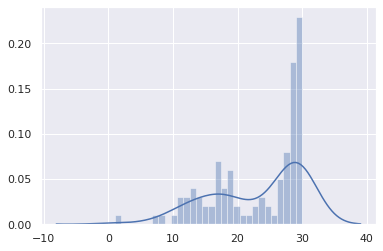

In [19]:
mmse_list = []
for mmse in df_cookie.mmse: 
  mmse_list.append(int(mmse))
print(np.mean(mmse_list))

mean_list = [np.mean(mmse_list)]*len(mmse_list)

from sklearn.metrics import mean_squared_error,mean_absolute_error
print(np.sqrt(mean_squared_error(mmse_list,mean_list)))
print(mean_absolute_error(mmse_list,mean_list))
import seaborn as sns, numpy as np
sns.set(); np.random.seed(0)
x = np.random.randn(100)
ax = sns.distplot(mmse_list,bins=30)


In [20]:
REAL_TEST = False   

from collections import defaultdict
dict_list = defaultdict(list)

n_folds = 5
test_percentage = 1/n_folds
df_len = len(df)

for i in range(n_folds): 
  !rm -r outputs
  !mkdir outputs 
  ##TODO recupera cose. 
  number_of_samples = int(df_len*test_percentage)

  msk = np.random.rand(len(df)) > 0


  if not GENERATE_TRANSFER_LEARNING: 
    msk[i*number_of_samples:(i+1)*number_of_samples] = False

  #msk2 = np.random.rand(len(df)) > 0.7
  #msk = np.array(msk) & np.array(msk2)
  df_cookie.sample(frac=1, random_state=1).reset_index(drop=True)
  if not REAL_TEST: 
    train_ = df_cookie[msk]
    test_ = df_cookie[~msk]

    train_df = pd.DataFrame({
        'id':range(len(train_)),
        'label':train_.mmse,
        'alpha':['a']*train_.shape[0],
        'text': train_.text,
        #'lang': int(tokenizer.lang2id['en'])
    })
    
    dev_df = pd.DataFrame({
        'id':range(len(test_)),
        'label':test_.mmse,
        'alpha':['a']*test_.shape[0],
        'text': test_.text,
        #'lang': int(tokenizer.lang2id['it'])
    })

  else: 
    train_df = pd.DataFrame({
        'id':range(len(df_cookie)),
        'label':df_cookie.mmse,
        'alpha':['a']*df_cookie.shape[0],
        'text': df_cookie.text,
        #'lang': int(tokenizer.lang2id['en'])
    })

    dev_df = pd.DataFrame({
        'id':range(len(df_real_test)),
        'label':df_real_test.mmse,
        'alpha':['a']*df_real_test.shape[0],
        'text': df_real_test.text,
        #'lang': int(tokenizer.lang2id['it'])
    })


  dev_df.to_csv('data/dev.tsv', sep='\t', index=False, header=False, columns=dev_df.columns)
  train_df.to_csv('data/train.tsv', sep='\t', index=False, header=False, columns=train_df.columns)

  if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    
    ## chose a pretrained model 
    #model = model_class.from_pretrained(args['model_name'])
    
    ## the model is not pretrained 
    model = model_class(config)

    model.to(device);
    if not ONE_SHOT: 
      global_step, tr_loss = train(train_dataset, model, tokenizer)
      logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

  if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    
    if GENERATE_TRANSFER_LEARNING: 
      model_to_save.save_pretrained('./drive/My Drive/Thesis/xlm_english_trained/')
      tokenizer.save_pretrained('./drive/My Drive/Thesis/xlm_english_trained/')
    else:
      model_to_save.save_pretrained(args['output_dir'])
      tokenizer.save_pretrained(args['output_dir'])
      
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))
    results = {}
    if GENERATE_TRANSFER_LEARNING: 
      logger.info('STOPPING TRAINING, DATASET GENERATED')
      break 

    if args['do_eval']:
        checkpoints = [args['output_dir']]
        if args['eval_all_checkpoints']:
            checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
            logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
            model = model_class.from_pretrained(checkpoint)
            model.to(device)
            result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
            result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
            results.update(result)

            for k, v in results.items():
              try: 
                dict_list[k].append(v)
              except Exception as e: 
                print(e)
  if REAL_TEST: 
    break 


rm: cannot remove 'outputs': No such file or directory


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 84/84 [00:00<00:00, 414.48it/s]
INFO:__main__:Saving features into cached file data/cached_train_distilbert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 84
INFO:__main__:  Num Epochs = 45
INFO:__main__:  Total train batch size  = 4
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 585
INFO:__main__: TIPO DEL DATASET: <class 'torch.utils.data.dataset.TensorDataset'>
Epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


871.259460

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


74.336998


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


INFO:wandb.run_manager:system metrics and metadata threads started
INFO:wandb.run_manager:checking resume status, waiting at most 10 seconds
INFO:wandb.run_manager:resuming run from id: UnVuOnYxOnVjcnIycGlzOmJlcnRfaXRhX3RyYWluOmZsYXZpb2RpcGFsbw==
INFO:wandb.run_manager:upserting run before process can begin, waiting at most 10 seconds
INFO:wandb.run_manager:saving patches
INFO:wandb.run_manager:saving pip packages
INFO:wandb.run_manager:initializing streaming files api
INFO:wandb.run_manager:unblocking file change observer, beginning sync with W&B servers
Epoch:   2%|▏         | 1/45 [00:01<01:12,  1.65s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


400.353394

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200430_132512-ucrr2pis/config.yaml


74.816505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200430_132512-ucrr2pis/requirements.txt
Epoch:   4%|▍         | 2/45 [00:02<01:00,  1.40s/it]

166.071136


Epoch:   7%|▋         | 3/45 [00:03<00:50,  1.20s/it]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


188.209885


Epoch:   9%|▉         | 4/45 [00:03<00:44,  1.08s/it]

280.566895

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


173.667267


Epoch:  11%|█         | 5/45 [00:04<00:39,  1.00it/s]

170.125977

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


121.510498


Epoch:  13%|█▎        | 6/45 [00:05<00:36,  1.07it/s]

71.995087


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  16%|█▌        | 7/45 [00:06<00:33,  1.13it/s]

79.837883


Epoch:  18%|█▊        | 8/45 [00:07<00:31,  1.18it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


79.037506


Epoch:  20%|██        | 9/45 [00:07<00:29,  1.21it/s]

48.631981

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


57.224163


Epoch:  22%|██▏       | 10/45 [00:08<00:29,  1.20it/s]

62.458626

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


37.195251


Epoch:  24%|██▍       | 11/45 [00:09<00:29,  1.17it/s]

31.642935

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  27%|██▋       | 12/45 [00:10<00:27,  1.19it/s]

33.427841


Epoch:  29%|██▉       | 13/45 [00:11<00:26,  1.22it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


63.626305


Epoch:  31%|███       | 14/45 [00:12<00:25,  1.23it/s]

63.363270

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


35.090405


Epoch:  33%|███▎      | 15/45 [00:12<00:23,  1.25it/s]

161.424683

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


76.279449


Epoch:  36%|███▌      | 16/45 [00:13<00:22,  1.27it/s]

21.662201


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  38%|███▊      | 17/45 [00:14<00:22,  1.25it/s]

32.037125


Epoch:  40%|████      | 18/45 [00:15<00:21,  1.26it/s]

41.136314

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


36.957195


Epoch:  42%|████▏     | 19/45 [00:15<00:20,  1.27it/s]

21.922375

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


29.590923


Epoch:  44%|████▍     | 20/45 [00:16<00:19,  1.28it/s]

20.713081

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


11.227547


Epoch:  47%|████▋     | 21/45 [00:17<00:18,  1.28it/s]

10.476309


Epoch:  49%|████▉     | 22/45 [00:18<00:17,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


5.105431


Epoch:  51%|█████     | 23/45 [00:19<00:17,  1.29it/s]

7.738152

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


13.711258


Epoch:  53%|█████▎    | 24/45 [00:19<00:16,  1.27it/s]

6.808611

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


13.402039


Epoch:  56%|█████▌    | 25/45 [00:20<00:15,  1.28it/s]

6.889651


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  58%|█████▊    | 26/45 [00:21<00:14,  1.29it/s]

15.457362


Epoch:  60%|██████    | 27/45 [00:22<00:14,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.310472


Epoch:  62%|██████▏   | 28/45 [00:22<00:13,  1.28it/s]

3.417926

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


11.512293


Epoch:  64%|██████▍   | 29/45 [00:23<00:12,  1.28it/s]

5.280342

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


5.613315


Epoch:  67%|██████▋   | 30/45 [00:24<00:11,  1.28it/s]

1.367455


Epoch:  69%|██████▉   | 31/45 [00:25<00:10,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.338668


Epoch:  71%|███████   | 32/45 [00:26<00:10,  1.29it/s]

3.377011

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.469969


Epoch:  73%|███████▎  | 33/45 [00:26<00:09,  1.30it/s]

1.647543

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.639692


Epoch:  76%|███████▌  | 34/45 [00:27<00:08,  1.31it/s]

1.768683


Epoch:  78%|███████▊  | 35/45 [00:28<00:07,  1.31it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.679485


Epoch:  80%|████████  | 36/45 [00:29<00:06,  1.30it/s]

1.258913

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.713137


Epoch:  82%|████████▏ | 37/45 [00:29<00:06,  1.29it/s]

1.932975

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.415264


Epoch:  84%|████████▍ | 38/45 [00:30<00:05,  1.30it/s]

2.250060


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  87%|████████▋ | 39/45 [00:31<00:04,  1.29it/s]

1.546426


Epoch:  89%|████████▉ | 40/45 [00:32<00:03,  1.27it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.664926


Epoch:  91%|█████████ | 41/45 [00:32<00:03,  1.28it/s]

0.334925

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.160729


Epoch:  93%|█████████▎| 42/45 [00:33<00:02,  1.28it/s]

0.291090

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.098786


Epoch:  96%|█████████▌| 43/45 [00:34<00:01,  1.28it/s]

1.736205


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  98%|█████████▊| 44/45 [00:35<00:00,  1.28it/s]

1.733772


Epoch: 100%|██████████| 45/45 [00:36<00:00,  1.25it/s]
INFO:__main__: global_step = 585, average loss = 57.1887135121048
INFO:__main__:Saving model checkpoint to outputs/
INFO:transformers.configuration_utils:Configuration saved in outputs/config.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:__main__:Evaluate the following checkpoints: ['outputs']
INFO:transformers.configuration_utils:loading configuration file outputs/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 1,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": "binary",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_dec

INFO:__main__:***** Eval results  *****
INFO:__main__:  mae = 4.0570517
INFO:__main__:  r_2 = 0.2164902007138796
INFO:__main__:  rmse = 5.1038947



[13.694914 18.370932 23.85398  17.239492 21.917011 28.880985 17.654613
 19.832483 13.296687 18.535433 22.732603 20.801897 23.906116 15.1108
 17.046133 11.109938 16.695381 24.941164 29.666124 13.411784]


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 84/84 [00:00<00:00, 385.30it/s]
INFO:__main__:Saving features into cached file data/cached_train_distilbert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 84
INFO:__main__:  Num Epochs = 45
INFO:__main__:  Total train batch size  = 4
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 585
INFO:__main__: TIPO DEL DATASET: <class 'torch.utils.data.dataset.TensorDataset'>
Epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


225.960571


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:   2%|▏         | 1/45 [00:00<00:34,  1.28it/s]

220.528778


Epoch:   4%|▍         | 2/45 [00:01<00:33,  1.29it/s]

318.621094

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


134.594910


Epoch:   7%|▋         | 3/45 [00:02<00:32,  1.29it/s]

158.632721

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


103.490105


Epoch:   9%|▉         | 4/45 [00:03<00:31,  1.28it/s]

148.049667


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  11%|█         | 5/45 [00:03<00:31,  1.28it/s]

95.851158


Epoch:  13%|█▎        | 6/45 [00:04<00:30,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


55.411438


Epoch:  16%|█▌        | 7/45 [00:05<00:29,  1.29it/s]

93.323090

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


73.272789


Epoch:  18%|█▊        | 8/45 [00:06<00:28,  1.28it/s]

48.188595

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


35.127579


Epoch:  20%|██        | 9/45 [00:06<00:27,  1.29it/s]

33.877041


Epoch:  22%|██▏       | 10/45 [00:07<00:27,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


44.660454


Epoch:  24%|██▍       | 11/45 [00:08<00:26,  1.29it/s]

33.916512

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


23.031073


Epoch:  27%|██▋       | 12/45 [00:09<00:25,  1.29it/s]

22.753922

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


32.005798


Epoch:  29%|██▉       | 13/45 [00:10<00:24,  1.29it/s]

33.498756


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  31%|███       | 14/45 [00:10<00:24,  1.29it/s]

47.638241


Epoch:  33%|███▎      | 15/45 [00:11<00:23,  1.29it/s]

37.824245

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


36.872345


Epoch:  36%|███▌      | 16/45 [00:12<00:22,  1.29it/s]

24.742397

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


41.980976


Epoch:  38%|███▊      | 17/45 [00:13<00:21,  1.30it/s]

7.250033

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


35.152718


Epoch:  40%|████      | 18/45 [00:13<00:20,  1.30it/s]

29.161716


Epoch:  42%|████▏     | 19/45 [00:14<00:19,  1.30it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


4.900044


Epoch:  44%|████▍     | 20/45 [00:15<00:19,  1.30it/s]

11.761991

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.749671


Epoch:  47%|████▋     | 21/45 [00:16<00:18,  1.30it/s]

2.491459

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.070035


Epoch:  49%|████▉     | 22/45 [00:16<00:17,  1.31it/s]

1.936748


Epoch:  51%|█████     | 23/45 [00:17<00:16,  1.30it/s]INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.233082


Epoch:  53%|█████▎    | 24/45 [00:18<00:16,  1.29it/s]

6.047093

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.485309


Epoch:  56%|█████▌    | 25/45 [00:19<00:15,  1.29it/s]

1.619384

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.818471


Epoch:  58%|█████▊    | 26/45 [00:20<00:14,  1.28it/s]

0.967813


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  60%|██████    | 27/45 [00:20<00:14,  1.28it/s]

0.927186


Epoch:  62%|██████▏   | 28/45 [00:21<00:13,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.596946


Epoch:  64%|██████▍   | 29/45 [00:22<00:12,  1.27it/s]

2.711581

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.350198


Epoch:  67%|██████▋   | 30/45 [00:23<00:11,  1.27it/s]

0.975956

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


5.133451


Epoch:  69%|██████▉   | 31/45 [00:24<00:11,  1.26it/s]

5.348728


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  71%|███████   | 32/45 [00:24<00:10,  1.27it/s]

1.890291


Epoch:  73%|███████▎  | 33/45 [00:25<00:09,  1.27it/s]

2.725179

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.360636


Epoch:  76%|███████▌  | 34/45 [00:26<00:08,  1.26it/s]

1.390877

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.214421


Epoch:  78%|███████▊  | 35/45 [00:27<00:07,  1.27it/s]

0.806550

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.571268


Epoch:  80%|████████  | 36/45 [00:27<00:07,  1.27it/s]

0.542141


Epoch:  82%|████████▏ | 37/45 [00:28<00:06,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.610653


Epoch:  84%|████████▍ | 38/45 [00:29<00:05,  1.28it/s]

2.092509

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.950044


Epoch:  87%|████████▋ | 39/45 [00:30<00:04,  1.29it/s]

0.590896

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.605614


Epoch:  89%|████████▉ | 40/45 [00:31<00:03,  1.28it/s]

0.667314


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  91%|█████████ | 41/45 [00:31<00:03,  1.28it/s]

1.427761


Epoch:  93%|█████████▎| 42/45 [00:32<00:02,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.731575


Epoch:  96%|█████████▌| 43/45 [00:33<00:01,  1.29it/s]

0.783230

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.617393


Epoch:  98%|█████████▊| 44/45 [00:34<00:00,  1.27it/s]

0.784108

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.566332


Epoch: 100%|██████████| 45/45 [00:35<00:00,  1.29it/s]
INFO:__main__: global_step = 585, average loss = 47.533882226954155
INFO:__main__:Saving model checkpoint to outputs/
INFO:transformers.configuration_utils:Configuration saved in outputs/config.json


INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:__main__:Evaluate the following checkpoints: ['outputs']
INFO:transformers.configuration_utils:loading configuration file outputs/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 1,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": "binary",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 

INFO:__main__:***** Eval results  *****
INFO:__main__:  mae = 6.3639092
INFO:__main__:  r_2 = -1.1766948746614183
INFO:__main__:  rmse = 7.7435455



[25.469946 24.629822 17.061256 19.866716 22.547783 19.15161  26.122986
 22.828827 17.229544 23.112352 24.638844 26.189201 17.72358  13.036309
 28.65615  27.516174 27.780687 24.162102 19.314617 18.988966]


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 84/84 [00:00<00:00, 348.13it/s]
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:__main__:Saving features into cached file data/cached_train_distilbert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 84
INFO:__main__:  Num Epochs = 45
INFO:__main__:  Total train batch size  = 4
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 585
INFO:__main__: TIPO DEL DATASET: <class 'torch.utils.data.dataset.TensorDataset'>
Epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


411.798676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   2%|▏         | 1/45 [00:00<00:33,  1.30it/s]

270.835907

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


280.385071


Epoch:   4%|▍         | 2/45 [00:01<00:33,  1.30it/s]

220.072861


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:   7%|▋         | 3/45 [00:02<00:32,  1.29it/s]

131.905365


Epoch:   9%|▉         | 4/45 [00:03<00:31,  1.30it/s]

99.858047

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


23.194809


Epoch:  11%|█         | 5/45 [00:03<00:30,  1.30it/s]

55.166061

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


128.092255


Epoch:  13%|█▎        | 6/45 [00:04<00:30,  1.30it/s]

38.310104

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


114.974243


Epoch:  16%|█▌        | 7/45 [00:05<00:29,  1.28it/s]

60.186073


Epoch:  18%|█▊        | 8/45 [00:06<00:28,  1.29it/s]INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


60.718182


Epoch:  20%|██        | 9/45 [00:06<00:28,  1.28it/s]

38.579048

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


50.829796


Epoch:  22%|██▏       | 10/45 [00:07<00:27,  1.28it/s]

54.933708

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


79.438835


Epoch:  24%|██▍       | 11/45 [00:08<00:26,  1.27it/s]

70.627579

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  27%|██▋       | 12/45 [00:09<00:25,  1.28it/s]

30.421387


Epoch:  29%|██▉       | 13/45 [00:10<00:24,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


47.741547


Epoch:  31%|███       | 14/45 [00:10<00:24,  1.27it/s]

41.099659

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


65.719185


Epoch:  33%|███▎      | 15/45 [00:11<00:23,  1.29it/s]

33.153473

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


46.914436


Epoch:  36%|███▌      | 16/45 [00:12<00:22,  1.27it/s]

21.756523


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  38%|███▊      | 17/45 [00:13<00:22,  1.27it/s]

48.030819


Epoch:  40%|████      | 18/45 [00:14<00:21,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


23.929319


Epoch:  42%|████▏     | 19/45 [00:14<00:20,  1.28it/s]

17.262213

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


3.524859


Epoch:  44%|████▍     | 20/45 [00:15<00:19,  1.28it/s]

11.810270

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.585254


Epoch:  47%|████▋     | 21/45 [00:16<00:18,  1.28it/s]

1.250958


Epoch:  49%|████▉     | 22/45 [00:17<00:17,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.675539


Epoch:  51%|█████     | 23/45 [00:17<00:17,  1.29it/s]

4.252319

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


25.046783


Epoch:  53%|█████▎    | 24/45 [00:18<00:16,  1.27it/s]

26.612564

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


14.821753

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.151847


Epoch:  56%|█████▌    | 25/45 [00:19<00:15,  1.28it/s]

13.938224


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  58%|█████▊    | 26/45 [00:20<00:14,  1.28it/s]

0.654395


Epoch:  60%|██████    | 27/45 [00:21<00:13,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.661777


Epoch:  62%|██████▏   | 28/45 [00:21<00:13,  1.29it/s]

0.552499

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.991319


Epoch:  64%|██████▍   | 29/45 [00:22<00:12,  1.29it/s]

2.393764

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.510622


Epoch:  67%|██████▋   | 30/45 [00:23<00:11,  1.28it/s]

1.856855


Epoch:  69%|██████▉   | 31/45 [00:24<00:10,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.848512


Epoch:  71%|███████   | 32/45 [00:24<00:10,  1.29it/s]

0.105661

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.736597


Epoch:  73%|███████▎  | 33/45 [00:25<00:09,  1.30it/s]

2.779651

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.271689


Epoch:  76%|███████▌  | 34/45 [00:26<00:08,  1.29it/s]

1.315556


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  78%|███████▊  | 35/45 [00:27<00:07,  1.28it/s]

0.858308


Epoch:  80%|████████  | 36/45 [00:28<00:06,  1.30it/s]

0.791521

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.483369


Epoch:  82%|████████▏ | 37/45 [00:28<00:06,  1.29it/s]

2.377466

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.680609


Epoch:  84%|████████▍ | 38/45 [00:29<00:05,  1.30it/s]

0.075550


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  87%|████████▋ | 39/45 [00:30<00:04,  1.30it/s]

0.834735


Epoch:  89%|████████▉ | 40/45 [00:31<00:03,  1.30it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.406426


Epoch:  91%|█████████ | 41/45 [00:31<00:03,  1.27it/s]

0.265313

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.110246


Epoch:  93%|█████████▎| 42/45 [00:32<00:02,  1.28it/s]

0.488715

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


3.740864


Epoch:  96%|█████████▌| 43/45 [00:33<00:01,  1.28it/s]

0.853469


Epoch:  98%|█████████▊| 44/45 [00:34<00:00,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.648541


Epoch: 100%|██████████| 45/45 [00:34<00:00,  1.29it/s]
INFO:__main__: global_step = 585, average loss = 48.02387925679358
INFO:__main__:Saving model checkpoint to outputs/
INFO:transformers.configuration_utils:Configuration saved in outputs/config.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
INFO:__main__:Evaluate the following checkpoints: ['outputs']
INFO:transformers.configuration_utils:loading configuration file outputs/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 1,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": "binary",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_dec

INFO:__main__:***** Eval results  *****
INFO:__main__:  mae = 2.8310966
INFO:__main__:  r_2 = 0.6872769583668294
INFO:__main__:  rmse = 3.930858



[15.830199 24.249224 16.052437 17.632032 17.764833 15.330746 27.873566
 27.769146 12.825514 29.680128 16.008265 29.70157  22.032967 28.209948
 29.574654 29.036972 29.51442  29.369312 27.507685 29.555468]


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 84/84 [00:00<00:00, 348.56it/s]
INFO:__main__:Saving features into cached file data/cached_train_distilbert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 84
INFO:__main__:  Num Epochs = 45
INFO:__main__:  Total train batch size  = 4
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 585
INFO:__main__: TIPO DEL DATASET: <class 'torch.utils.data.dataset.TensorDataset'>
Epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


86.859367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   2%|▏         | 1/45 [00:00<00:34,  1.28it/s]

321.528015

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


299.783264


Epoch:   4%|▍         | 2/45 [00:01<00:33,  1.28it/s]

215.302765

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


84.350250


Epoch:   7%|▋         | 3/45 [00:02<00:32,  1.28it/s]

244.285980


Epoch:   9%|▉         | 4/45 [00:03<00:31,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


18.855532


Epoch:  11%|█         | 5/45 [00:03<00:31,  1.28it/s]

67.443665

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


65.365463


Epoch:  13%|█▎        | 6/45 [00:04<00:30,  1.29it/s]

44.056877

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


44.977760

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


53.833733


Epoch:  16%|█▌        | 7/45 [00:05<00:29,  1.28it/s]

43.275330


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  18%|█▊        | 8/45 [00:06<00:28,  1.28it/s]

67.361160


Epoch:  20%|██        | 9/45 [00:06<00:27,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


38.964211


Epoch:  22%|██▏       | 10/45 [00:07<00:26,  1.30it/s]

26.207726

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


72.643349


Epoch:  24%|██▍       | 11/45 [00:08<00:26,  1.29it/s]

59.227959

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


57.108826

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


77.360413


Epoch:  27%|██▋       | 12/45 [00:09<00:25,  1.27it/s]

57.244774


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  29%|██▉       | 13/45 [00:10<00:25,  1.27it/s]

34.305466


Epoch:  31%|███       | 14/45 [00:10<00:24,  1.27it/s]

45.938614

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


40.892982


Epoch:  33%|███▎      | 15/45 [00:11<00:23,  1.28it/s]

37.942436

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


21.820576


Epoch:  36%|███▌      | 16/45 [00:12<00:22,  1.28it/s]

7.710608


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  38%|███▊      | 17/45 [00:13<00:21,  1.29it/s]

20.832020


Epoch:  40%|████      | 18/45 [00:14<00:21,  1.27it/s]

15.008430

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


30.050949


Epoch:  42%|████▏     | 19/45 [00:14<00:20,  1.27it/s]

4.557498

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


14.192550


Epoch:  44%|████▍     | 20/45 [00:15<00:19,  1.27it/s]

30.602301

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


12.729391


Epoch:  47%|████▋     | 21/45 [00:16<00:18,  1.27it/s]

19.565945


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  49%|████▉     | 22/45 [00:17<00:17,  1.28it/s]

0.598344


Epoch:  51%|█████     | 23/45 [00:17<00:17,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json


3.741283

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.070197


Epoch:  53%|█████▎    | 24/45 [00:18<00:16,  1.29it/s]

1.286055

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.043964


Epoch:  56%|█████▌    | 25/45 [00:19<00:15,  1.29it/s]

4.504601


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  58%|█████▊    | 26/45 [00:20<00:14,  1.29it/s]

2.348567


Epoch:  60%|██████    | 27/45 [00:21<00:13,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.436524


Epoch:  62%|██████▏   | 28/45 [00:21<00:13,  1.29it/s]

4.591846

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


3.258163


Epoch:  64%|██████▍   | 29/45 [00:22<00:12,  1.28it/s]

5.253620

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


4.195196


Epoch:  67%|██████▋   | 30/45 [00:23<00:11,  1.28it/s]

5.110945


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  69%|██████▉   | 31/45 [00:24<00:10,  1.29it/s]

1.756664


Epoch:  71%|███████   | 32/45 [00:24<00:10,  1.28it/s]

3.377336

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.083366


Epoch:  73%|███████▎  | 33/45 [00:25<00:09,  1.28it/s]

1.325978

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.617849


Epoch:  76%|███████▌  | 34/45 [00:26<00:08,  1.27it/s]

1.815164

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.289350


Epoch:  78%|███████▊  | 35/45 [00:27<00:07,  1.25it/s]

2.503269


Epoch:  80%|████████  | 36/45 [00:28<00:07,  1.27it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.911620


Epoch:  82%|████████▏ | 37/45 [00:28<00:06,  1.28it/s]

0.131183

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.053784


Epoch:  84%|████████▍ | 38/45 [00:29<00:05,  1.28it/s]

0.527168

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.443310


Epoch:  87%|████████▋ | 39/45 [00:30<00:04,  1.29it/s]

1.050790


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  89%|████████▉ | 40/45 [00:31<00:03,  1.28it/s]

0.323493


Epoch:  91%|█████████ | 41/45 [00:32<00:03,  1.28it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.370952


Epoch:  93%|█████████▎| 42/45 [00:32<00:02,  1.28it/s]

0.405292

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.246172


Epoch:  96%|█████████▌| 43/45 [00:33<00:01,  1.29it/s]

1.233102

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.384536


Epoch:  98%|█████████▊| 44/45 [00:34<00:00,  1.29it/s]

0.154776


Epoch: 100%|██████████| 45/45 [00:35<00:00,  1.28it/s]
INFO:__main__: global_step = 585, average loss = 38.14302302134725
INFO:__main__:Saving model checkpoint to outputs/
INFO:transformers.configuration_utils:Configuration saved in outputs/config.json


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:__main__:Evaluate the following checkpoints: ['outputs']
INFO:transformers.configuration_utils:loading configuration file outputs/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 1,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": "binary",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_dec

INFO:__main__:***** Eval results  *****
INFO:__main__:  mae = 2.851501
INFO:__main__:  r_2 = -13.26845037713647
INFO:__main__:  rmse = 3.7773602



[22.872717 29.792194 29.704962 29.593529 20.300117 28.298813 24.37003
 29.201296 27.493616 25.374706 29.868908 29.92931  28.666063 25.379345
 24.869638 26.600054 29.856262 28.446867 22.384405 22.64517 ]


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 84/84 [00:00<00:00, 370.97it/s]
INFO:__main__:Saving features into cached file data/cached_train_distilbert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 84
INFO:__main__:  Num Epochs = 45
INFO:__main__:  Total train batch size  = 4
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 585
INFO:__main__: TIPO DEL DATASET: <class 'torch.utils.data.dataset.TensorDataset'>
Epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


68.538025


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   2%|▏         | 1/45 [00:00<00:33,  1.30it/s]

173.293991


Epoch:   4%|▍         | 2/45 [00:01<00:33,  1.30it/s]

192.729614

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


253.825562


Epoch:   7%|▋         | 3/45 [00:02<00:32,  1.30it/s]

97.841003

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


24.388060


Epoch:   9%|▉         | 4/45 [00:03<00:31,  1.30it/s]

3.354513


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  11%|█         | 5/45 [00:03<00:30,  1.29it/s]

64.529564


Epoch:  13%|█▎        | 6/45 [00:04<00:30,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


113.731369


Epoch:  16%|█▌        | 7/45 [00:05<00:29,  1.30it/s]

64.234360

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


40.015671


Epoch:  18%|█▊        | 8/45 [00:06<00:28,  1.29it/s]

40.023544

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


99.393639


Epoch:  20%|██        | 9/45 [00:06<00:27,  1.29it/s]

50.385845


Epoch:  22%|██▏       | 10/45 [00:07<00:26,  1.30it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


86.107941


Epoch:  24%|██▍       | 11/45 [00:08<00:26,  1.29it/s]

66.508186

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


69.745819


Epoch:  27%|██▋       | 12/45 [00:09<00:25,  1.29it/s]

36.694706

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


79.516533


Epoch:  29%|██▉       | 13/45 [00:10<00:24,  1.29it/s]

76.017685


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  31%|███       | 14/45 [00:10<00:23,  1.30it/s]

66.313950


Epoch:  33%|███▎      | 15/45 [00:11<00:23,  1.30it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


25.662085


Epoch:  36%|███▌      | 16/45 [00:12<00:22,  1.29it/s]

35.009491

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.966543


Epoch:  38%|███▊      | 17/45 [00:13<00:21,  1.30it/s]

12.451644


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


Epoch:  40%|████      | 18/45 [00:13<00:20,  1.30it/s]

16.350372


Epoch:  42%|████▏     | 19/45 [00:14<00:19,  1.31it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


8.669219


Epoch:  44%|████▍     | 20/45 [00:15<00:19,  1.30it/s]

2.735769

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.460880


Epoch:  47%|████▋     | 21/45 [00:16<00:18,  1.30it/s]

1.568439

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


20.756163


Epoch:  49%|████▉     | 22/45 [00:16<00:17,  1.30it/s]

1.739395


Epoch:  51%|█████     | 23/45 [00:17<00:16,  1.31it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.008487


Epoch:  53%|█████▎    | 24/45 [00:18<00:16,  1.29it/s]

7.362664

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


5.752849


Epoch:  56%|█████▌    | 25/45 [00:19<00:15,  1.28it/s]

0.753281

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


2.285026


Epoch:  58%|█████▊    | 26/45 [00:20<00:14,  1.28it/s]

5.258118


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  60%|██████    | 27/45 [00:20<00:14,  1.27it/s]

3.109536


Epoch:  62%|██████▏   | 28/45 [00:21<00:13,  1.27it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


3.622276


Epoch:  64%|██████▍   | 29/45 [00:22<00:12,  1.27it/s]

1.390149

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


5.481250


Epoch:  67%|██████▋   | 30/45 [00:23<00:12,  1.25it/s]

3.942746

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.848108


Epoch:  69%|██████▉   | 31/45 [00:24<00:11,  1.26it/s]

1.183570


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  71%|███████   | 32/45 [00:24<00:10,  1.26it/s]

2.002251


Epoch:  73%|███████▎  | 33/45 [00:25<00:09,  1.26it/s]

2.083464

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.429679


Epoch:  76%|███████▌  | 34/45 [00:26<00:08,  1.27it/s]

0.358664

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.483338


Epoch:  78%|███████▊  | 35/45 [00:27<00:07,  1.27it/s]

0.692430

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.154110


Epoch:  80%|████████  | 36/45 [00:28<00:07,  1.26it/s]

0.325428


INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl
Epoch:  82%|████████▏ | 37/45 [00:28<00:06,  1.27it/s]

2.216135


Epoch:  84%|████████▍ | 38/45 [00:29<00:05,  1.28it/s]

0.288211

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.189049


Epoch:  87%|████████▋ | 39/45 [00:30<00:04,  1.28it/s]

2.113627

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.296808


Epoch:  89%|████████▉ | 40/45 [00:31<00:03,  1.28it/s]

0.994628

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.564411


Epoch:  91%|█████████ | 41/45 [00:31<00:03,  1.28it/s]

0.090497


Epoch:  93%|█████████▎| 42/45 [00:32<00:02,  1.29it/s]

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.213159


Epoch:  96%|█████████▌| 43/45 [00:33<00:01,  1.28it/s]

1.503171

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


0.877390


Epoch:  98%|█████████▊| 44/45 [00:34<00:00,  1.29it/s]

0.272676

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-history.jsonl


1.288443


Epoch: 100%|██████████| 45/45 [00:35<00:00,  1.29it/s]
INFO:__main__: global_step = 585, average loss = 38.017317725030274
INFO:__main__:Saving model checkpoint to outputs/
INFO:transformers.configuration_utils:Configuration saved in outputs/config.json


INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:__main__:Evaluate the following checkpoints: ['outputs']
INFO:transformers.configuration_utils:loading configuration file outputs/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 1,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": "binary",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 

INFO:__main__:***** Eval results  *****
INFO:__main__:  mae = 2.391021
INFO:__main__:  r_2 = -9.76720011416341
INFO:__main__:  rmse = 3.6354833



[26.985502 29.531488 29.456013 29.711378 22.214449 22.50335  27.556353
 29.172598 22.603922 28.663467 27.965403 29.658657 29.56316  25.166365
 29.670357 18.563046 29.716263 28.166464 26.816692 27.18056 ]
Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f00ed132e18> (for post_run_cell):


NotebookValidationError: ignored

In [21]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200430_132512-ucrr2pis/wandb-metadata.json


Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f00ed132e18> (for post_run_cell):


NotebookValidationError: ignored

In [22]:
print(dict_list)
for k in dict_list:
  print(k, np.mean(dict_list[k]))

defaultdict(<class 'list'>, {'rmse_': [5.1038947, 7.7435455, 3.930858, 3.7773602, 3.6354833], 'r_2_': [0.2164902007138796, -1.1766948746614183, 0.6872769583668294, -13.26845037713647, -9.76720011416341], 'mae_': [4.0570517, 6.3639092, 2.8310966, 2.851501, 2.391021]})
rmse_ 4.8382287
r_2_ -4.661715641376118
mae_ 3.6989162
Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f00ed132e18> (for post_run_cell):


NotebookValidationError: ignored